In [3]:
# Import existing code modules
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#from matplotlib.colors import ListedColormap
#import cmaps
import geocat.viz as gv

In [4]:
#open the files   
ds= xr.open_dataset('C:/Dinis_MOZ/Wind/VWS/VWSf_1980_2020.nc') 
ds.data_vars

Data variables:
    vws      (time, latitude, longitude) float64 ...

In [5]:
#specify the period of interest
ds1= ds.sel(time=slice("2000-01-01", "2020-12-01"))
ds2= ds.sel(time=slice("1980-01-01", "2020-12-01"))

In [6]:
AA=ds2.mean('time') 
BB=ds1.mean('time') 

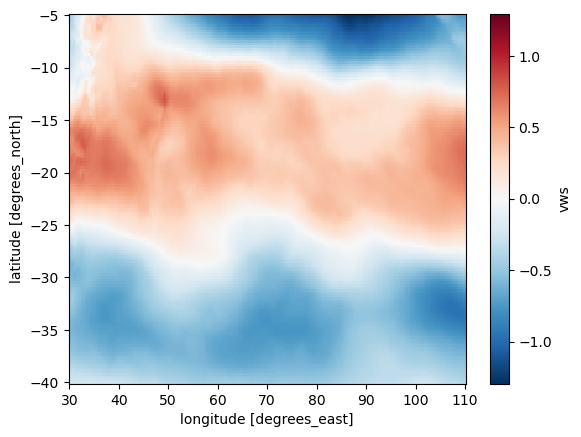

In [7]:
diff = AA-BB
diff.vws.plot()

In [109]:
#open the siginificance files    
#d4 = xr.open_dataset('C:/Dinis_MOZ/Wind/VWS/vws_pvalue_tc_high-tc_low_diff.nc')
#diff_sig.sig.plot()

In [110]:
d4.coords['longitude']=(d4.coords['longitude']+180)%360-180
d5=d4.sortby(d4.longitude)
diff_sig=d5.sig

In [111]:
#clim = ds.mean('time')

In [112]:
#clim.vws.plot()

In [113]:
#open the files   
d6= xr.open_dataset('C:/Dinis_MOZ/Wind/VWS/Wind_UV_Ttest.nc') 
d6.data_vars

Data variables:
    u        (time, latitude, longitude) float64 ...
    v        (time, latitude, longitude) float64 ...

In [114]:
#specify the period of interest
#d7= d6.sel(time=slice("1980-01-01", "1999-12-01"))

In [115]:
####For yearly analysis
#d9=d6.groupby('time.year').mean('time')
#d8

In [116]:
#Make an average of the wind variables
wspd_wind = np.mean(np.sqrt(np.add(np.square(d6.u),np.square(d6.v))),axis=0)
u_wind = np.mean(d6.u,axis=0)
v_wind = np.mean(d6.v,axis=0)
#v_wind

In [117]:
#setting up the quiver arguments (these display the wind vectors on the plot)
xx_wind = wspd_wind.longitude.values
yy_wind = wspd_wind.latitude.values
X_wind,Y_wind =np.meshgrid(xx_wind, yy_wind)
U_wind = u_wind.data
V_wind = v_wind.data

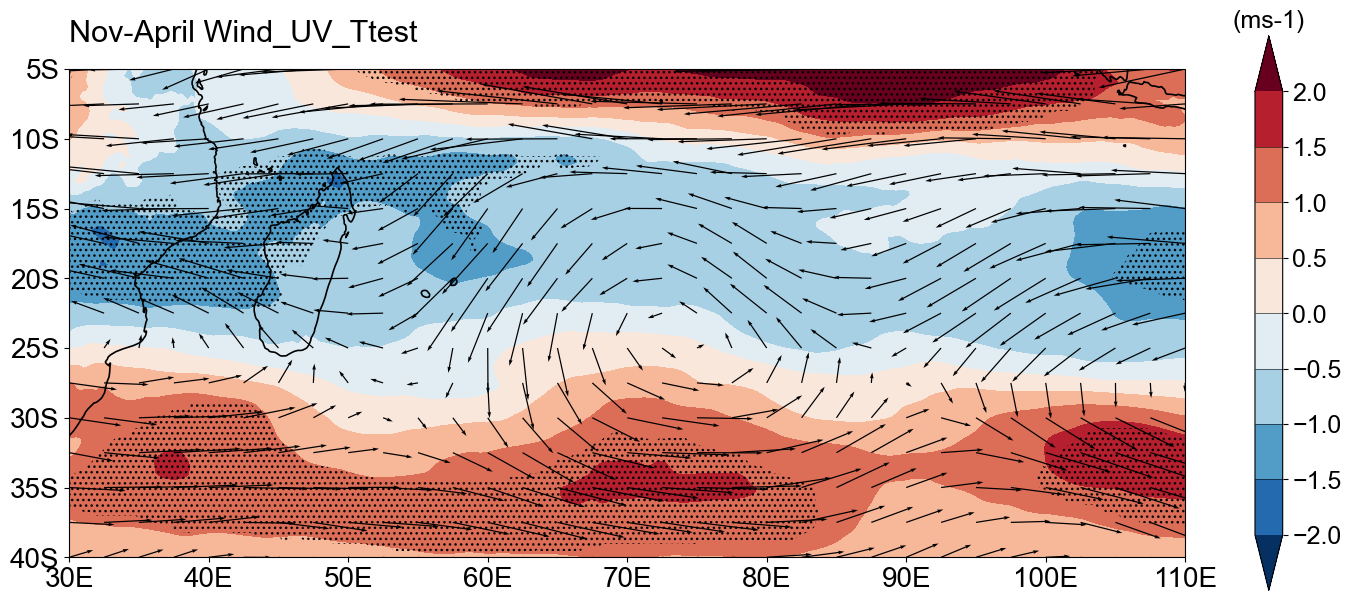

In [120]:
##### plotting
# Create a wider than normal figure to support our many plots
fig = plt.figure(figsize=(18,9))
plt.gcf().subplots_adjust(hspace=0.1, wspace=1)
plt.rcParams["font.family"] = "Arial"



def Plot(row, col, pos, diff, diff_sig, clevs, cbar_label, title):
    # Generate axes, using cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()#(central_longitude=0)
    ax = fig.add_subplot(row, col, pos, projection=projection)
    #plt.xlim([-50, 100])
    #plt.ylim([-50, 40])
    #plt.gca().set_yticks(np.arange(-50,50,20),crs=ccrs.PlateCarree())
    #plt.gca().set_xticks(np.arange(-50,110,25),crs=ccrs.PlateCarree())
    plt.xlim([30, 110])
    plt.ylim([-40, -5])
    plt.gca().set_xticks(np.arange(30,120,10),crs=ccrs.PlateCarree())
    plt.gca().set_yticks(np.arange(-40,0,5),crs=ccrs.PlateCarree())
    lon_formatter=LongitudeFormatter(degree_symbol=''); lat_formatter=LatitudeFormatter(degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter); ax.yaxis.set_major_formatter(lat_formatter);ax.tick_params(labelsize=20)
    xticks = ax.xaxis.get_major_ticks(); xticks[2].set_visible(True)
    
   # ax.coastlines(resolution='10m', color='black',linewidth=10)
    #ax.coastlines(resolution='10m', color='black', linewidth=0.7)
    #ax.add_feature(cfeature.BORDERS, linewidth=0.1)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Contourf-plot data
    temp = diff.vws.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=clevs,
                           cmap=plt.cm.RdBu_r,
                           add_colorbar=False,
                           extend='both')
    
    #ax.coastlines(resolution='10m', color='black',linewidth=1)
    ax.coastlines(linewidth=1.2)
   # ax.add_feature(cfeature.BORDERS, linewidth=1)
     # Plot Hatch
    pval = diff_sig
    cond = (pval <= 0.05)
    ## Mask out the areas that do not satisfy the conditions
    sig = pval.where(cond)
    
    ## make a hatch of significance
    plt.contourf(sig.longitude,sig.latitude,sig,hatches=['...'],alpha=0,
                 transform=ccrs.PlateCarree()) 
    
        # Add color bar
    cbar = plt.colorbar(temp,
                        orientation='vertical',
                        shrink=0.8,
                        extendfrac='auto', 
                        extendrect=False, 
                        drawedges=True)

    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(clevs)
    cbar.ax.set_title(cbar_label, size=18)

    # Use geocat.viz.util convenience function to set titles and labels without calling several matplotlib functions
    gv.set_titles_and_labels(ax,
                            maintitle="",
                            lefttitle=title,
                            lefttitlefontsize=22,
                            righttitle="",
                            righttitlefontsize=22,
                            xlabel="",
                            ylabel="")


# define the levels for each variable
clevs  = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
#clevs  = [8, 12, 15, 18, 21, 24,27, 30]
Plot(1, 1, 1, diff, diff_sig, clevs, '(ms-1)', "Nov-April Wind_UV_Ttest  ")
#Plot(1, 1,1,1, diff, clevs, '(ms-1)', "Nov-April climatological 200 hPa - 850 hPa wind shear (1980-2020)")
plt.quiver(X_wind[::10, ::10], Y_wind[::10, ::10], U_wind[::10, ::10], V_wind[::10, ::10], 
           transform=ccrs.PlateCarree(), color='k', scale=25, width=0.0011,)
#plt.quiver(X_wind[::3, ::3], Y_wind[::3, ::3], U_wind[::3, ::3], V_wind[::3, ::3], 
#           transform=ccrs.PlateCarree(), color='k', scale=35, width=0.0011,)
fig.savefig('C:/Dinis_MOZ/Wind/VWS/Nov-April Wind_UV_Ttest.png', bbox_inches='tight', pad_inches = 0.1, dpi=300)
plt.show()